# Event-Related Pupil Dilations

We are often interested in how the pupil responds to certain events, for example stimuli. On method to investigate this question is to extract the average pupil-dilation surrounding the events of interest.

In [6]:
import sys
sys.path.insert(0,"..") # this is not needed if you have installed pypillometry
import pypillometry as pp
import numpy as np
import pylab as plt

Here, we will use the dataset created in the [importdata](/docs/html/docs/importdata.html) example. We download this dataset `test.pd` from the Github page.

In [2]:
d=pp.PupilData.from_file("https://github.com/ihrke/pypillometry/raw/master/data/test.pd")

Next, we apply a basic blink-detection and interpolation pipeline as illustrated in the [blinks](/docs/html/docs/blinks.html) example.

In [3]:
d.blinks_detect().blinks_merge(100).blinks_interp_mahot().lowpass_filter(cutoff=5).scale()
plt.figure(figsize=(15,5))
d.plot((2,3), units="min");

NameError: name 'plt' is not defined

Next, we want to create ERPDs based on some of the event-markers in this dataset. The markers in this set have a special structure where each label consists of information about experimental condition, block etc. We can take a look at the first few events:

In [ ]:
list(d.event_labels[0:5])

The first letter contains information about which stimulus was presented, the letter combination after the first underscore codes the experimental condition. We can use the dataset's `get_erpd()` function to extract the pupillary signal in the vicinity of some of these events. For that, we have to indicates which events we want to select by providing the `event_select` argument to that function. We start by extracting all stimuli coded as "C" (cues) by providing `event_select="C_"` as an argument. This will match all labels that contain the string "C_" somewhere. We set the name of the object to `"cue"` to distinguish this ERPD from others we will create soon. Finally, we apply a baseline-correction using the `baseline_win` parameter (setting this to `None` results in no baseline correction).

In [4]:
erpd_cue=d.get_erpd("cue", event_select="C_", baseline_win=(-200,0))
erpd_cue

ERPDSinglSubject(cue):
 dataset: test_to
 nevents: 75
 window : (-500.0, 2000.0)

This ERPD contains data from 75 trials and goes from 500 ms before the cue-onset until 2000 ms post-cue onset. We can use the `plot()` function of that object to visualize the curve. In addition to the mean curve and its standard error, we also get the percentage of missing (interpolated) datapoints in the dataset (the light blue curve). We can choose what is displayed as the errorbars by passing a function to `varfct`. For example, we can use `varfct=np.std` to display standard deviation instead of standard error.

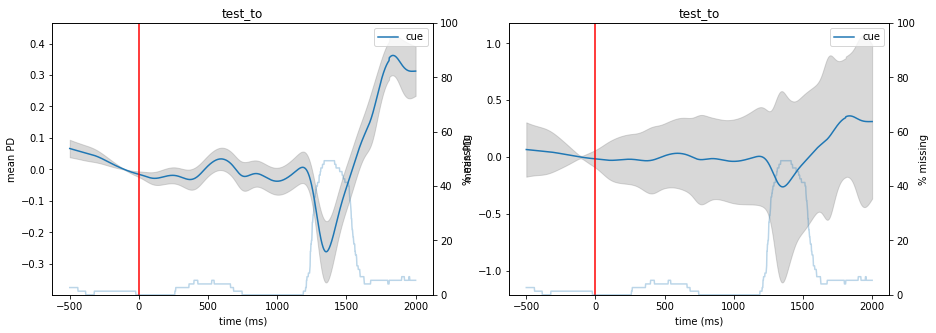

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
erpd_cue.plot()
plt.subplot(122)
erpd_cue.plot(varfct=np.std)

Sometimes, extracting labels based on string-matching alone is not sufficient. For example, in our current dataset, we would like to compare cues (labels starting with "C_") that come from condition "GW" and "NA" against the cues from conditions "NW" and "GA" (what exactly that means is not so important for the present purposes). We can achieve that by passing a filter-function as argument `event_select` instead of passing a string. Such a function should return `True` whenever a label should be used and `False` when it should not be used. Here is an example of two such functions, one for cues from the "GW"/NA" conditions (call them "congruent") and one for the "NW"/"GA" conditions (call them "conflict").

In [9]:
def is_conflict_cue(x):
    xs=x.split("_")
    if len(xs)>=2 and xs[0]=="C" and xs[1] in ["NW","GA"]:
        return True
    else:
        return False
def is_congruent_cue(x):
    xs=x.split("_")
    if len(xs)>=2 and xs[0]=="C" and xs[1] in ["GW","NA"]:
        return True
    else:
        return False

First, the label is split into parts using the substring "_". Further, we return `True` only when the first element is a "C" and the second element is one of the relevant conditions. We can try whether this function works, by applying them to some labels:

In [10]:
is_congruent_cue("C_GW"), is_congruent_cue("C_GA")

(True, False)

We can now get to ERPD objects, one for each of the filter-functions.

In [11]:
erpd_conf=d.get_erpd("conflict",  event_select=is_conflict_cue,  baseline_win=(-200,0))
erpd_cong=d.get_erpd("congruent", event_select=is_congruent_cue, baseline_win=(-200,0))

Finally, we can plot the two objects together. For that, we can pass one of the objects as an additional argument to the `plot_mean()` function of the other one:

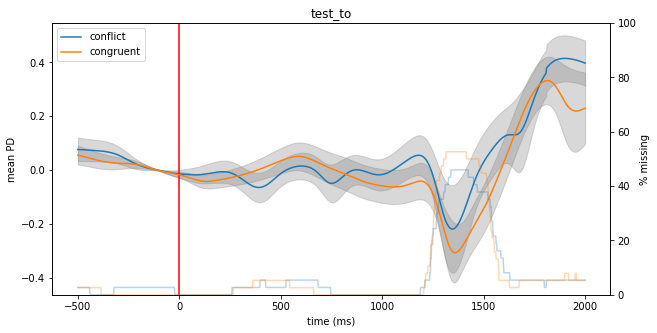

In [12]:
plt.figure(figsize=(10,5))
erpd_conf.plot(overlays=erpd_cong)